In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from keras.callbacks import EarlyStopping

In [2]:
# reading csv
dataset = pd.read_csv('yahoo_BTC-USD.csv')
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864,468.174,452.422,457.334,457.334,21056800.000
1,2014-09-18,456.860,456.860,413.104,424.440,424.440,34483200.000
2,2014-09-19,424.103,427.835,384.532,394.796,394.796,37919700.000
3,2014-09-20,394.673,423.296,389.883,408.904,408.904,36863600.000
4,2014-09-21,408.085,412.426,393.181,398.821,398.821,26580100.000
...,...,...,...,...,...,...,...
2449,2021-06-01,37293.793,37896.734,35787.086,36684.926,36684.926,34639423297.000
2450,2021-06-02,36699.922,38231.340,35966.309,37575.180,37575.180,33070867190.000
2451,2021-06-03,37599.410,39478.953,37243.973,39208.766,39208.766,35460750427.000
2452,2021-06-04,39242.484,39242.484,35717.723,36894.406,36894.406,41831090187.000


In [3]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
2039,2020-04-17,nan,nan,nan,nan,nan,nan
2214,2020-10-09,nan,nan,nan,nan,nan,nan
2217,2020-10-12,nan,nan,nan,nan,nan,nan
2218,2020-10-13,nan,nan,nan,nan,nan,nan


In [4]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2454 non-null   object 
 1   Open       2450 non-null   float64
 2   High       2450 non-null   float64
 3   Low        2450 non-null   float64
 4   Close      2450 non-null   float64
 5   Adj Close  2450 non-null   float64
 6   Volume     2450 non-null   float64
dtypes: float64(6), object(1)
memory usage: 134.3+ KB


In [5]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2450.000,2450.000,2450.000,2450.000,2450.000,2450.000
mean,7626.843,7844.916,7387.271,7640.137,7640.137,12616231026.884
std,11665.490,12032.959,11232.481,11676.218,11676.218,19727883639.959
min,176.897,211.731,171.510,178.103,178.103,5914570.000
25%,460.801,466.735,455.070,460.719,460.719,68730922.000
50%,4324.400,4403.835,4138.012,4330.050,4330.050,4010640000.000
75%,9193.489,9355.582,9030.895,9203.736,9203.736,18684308124.500
max,63523.754,64863.098,62208.965,63503.457,63503.457,350967941479.000


In [6]:
# use close only and fill NaN with ffil
df = dataset.set_index('Date')[['Close']].tail(2000)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

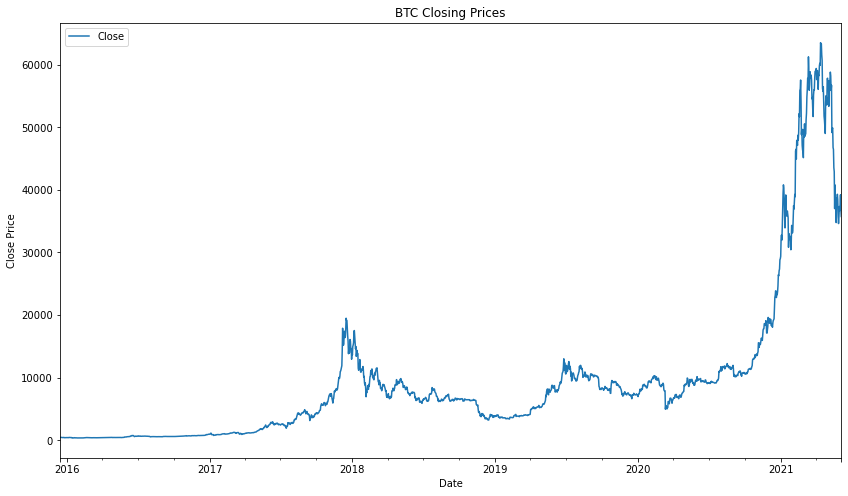

In [41]:
# plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title('BTC Closing Prices')
plt.ylabel('Close Price')
plt.show()

In [8]:
# train test split
prediction_days = 10
df_train = df.head(-prediction_days)
df_test = df.tail(prediction_days)
training_set = df_train.values
test_set = df_test.values
print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (1990, 1)
test_set.shape =  (10, 1)


In [9]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00159948],
       [0.00143497],
       [0.00145309],
       ...,
       [0.60725658],
       [0.60244565],
       [0.61657281]])

In [10]:
training_set_scaled.shape

(1990, 1)

In [11]:
len(training_set_scaled)

1990

In [12]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
 
n_future = prediction_days #20  # Number of days you want to predict into the future
n_past = 30  # Number of past days you want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, 0])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# another efficient and nice way
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# https://github.com/marcosan93/Price-Forecaster/blob/master/BTC-Models/BTC-RNN-Deep-Learning.ipynb
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
X, y = split_sequence(training_set, 60, 7)
X.shape, y.shape

In [13]:
X_train.shape, y_train.shape

((1951, 30), (1951, 10))

In [14]:
range(n_past, len(training_set_scaled) - n_future + 1)

range(30, 1981)

In [15]:
range(n_past, len(training_set_scaled)-7)

range(30, 1983)

In [16]:
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    print('i={}, [{}, {})'.format(i, i-n_past, i))

i=30, [0, 30)
i=31, [1, 31)
i=32, [2, 32)
i=33, [3, 33)
i=34, [4, 34)
i=35, [5, 35)
i=36, [6, 36)
i=37, [7, 37)
i=38, [8, 38)
i=39, [9, 39)
i=40, [10, 40)
i=41, [11, 41)
i=42, [12, 42)
i=43, [13, 43)
i=44, [14, 44)
i=45, [15, 45)
i=46, [16, 46)
i=47, [17, 47)
i=48, [18, 48)
i=49, [19, 49)
i=50, [20, 50)
i=51, [21, 51)
i=52, [22, 52)
i=53, [23, 53)
i=54, [24, 54)
i=55, [25, 55)
i=56, [26, 56)
i=57, [27, 57)
i=58, [28, 58)
i=59, [29, 59)
i=60, [30, 60)
i=61, [31, 61)
i=62, [32, 62)
i=63, [33, 63)
i=64, [34, 64)
i=65, [35, 65)
i=66, [36, 66)
i=67, [37, 67)
i=68, [38, 68)
i=69, [39, 69)
i=70, [40, 70)
i=71, [41, 71)
i=72, [42, 72)
i=73, [43, 73)
i=74, [44, 74)
i=75, [45, 75)
i=76, [46, 76)
i=77, [47, 77)
i=78, [48, 78)
i=79, [49, 79)
i=80, [50, 80)
i=81, [51, 81)
i=82, [52, 82)
i=83, [53, 83)
i=84, [54, 84)
i=85, [55, 85)
i=86, [56, 86)
i=87, [57, 87)
i=88, [58, 88)
i=89, [59, 89)
i=90, [60, 90)
i=91, [61, 91)
i=92, [62, 92)
i=93, [63, 93)
i=94, [64, 94)
i=95, [65, 95)
i=96, [66, 96)
i=97,

i=1906, [1876, 1906)
i=1907, [1877, 1907)
i=1908, [1878, 1908)
i=1909, [1879, 1909)
i=1910, [1880, 1910)
i=1911, [1881, 1911)
i=1912, [1882, 1912)
i=1913, [1883, 1913)
i=1914, [1884, 1914)
i=1915, [1885, 1915)
i=1916, [1886, 1916)
i=1917, [1887, 1917)
i=1918, [1888, 1918)
i=1919, [1889, 1919)
i=1920, [1890, 1920)
i=1921, [1891, 1921)
i=1922, [1892, 1922)
i=1923, [1893, 1923)
i=1924, [1894, 1924)
i=1925, [1895, 1925)
i=1926, [1896, 1926)
i=1927, [1897, 1927)
i=1928, [1898, 1928)
i=1929, [1899, 1929)
i=1930, [1900, 1930)
i=1931, [1901, 1931)
i=1932, [1902, 1932)
i=1933, [1903, 1933)
i=1934, [1904, 1934)
i=1935, [1905, 1935)
i=1936, [1906, 1936)
i=1937, [1907, 1937)
i=1938, [1908, 1938)
i=1939, [1909, 1939)
i=1940, [1910, 1940)
i=1941, [1911, 1941)
i=1942, [1912, 1942)
i=1943, [1913, 1943)
i=1944, [1914, 1944)
i=1945, [1915, 1945)
i=1946, [1916, 1946)
i=1947, [1917, 1947)
i=1948, [1918, 1948)
i=1949, [1919, 1949)
i=1950, [1920, 1950)
i=1951, [1921, 1951)
i=1952, [1922, 1952)
i=1953, [1923

In [17]:
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    print('i={}, [{}, {})'.format(i, i, i+n_future)) #  i,'-', i, '-', i+n_future)

i=30, [30, 40)
i=31, [31, 41)
i=32, [32, 42)
i=33, [33, 43)
i=34, [34, 44)
i=35, [35, 45)
i=36, [36, 46)
i=37, [37, 47)
i=38, [38, 48)
i=39, [39, 49)
i=40, [40, 50)
i=41, [41, 51)
i=42, [42, 52)
i=43, [43, 53)
i=44, [44, 54)
i=45, [45, 55)
i=46, [46, 56)
i=47, [47, 57)
i=48, [48, 58)
i=49, [49, 59)
i=50, [50, 60)
i=51, [51, 61)
i=52, [52, 62)
i=53, [53, 63)
i=54, [54, 64)
i=55, [55, 65)
i=56, [56, 66)
i=57, [57, 67)
i=58, [58, 68)
i=59, [59, 69)
i=60, [60, 70)
i=61, [61, 71)
i=62, [62, 72)
i=63, [63, 73)
i=64, [64, 74)
i=65, [65, 75)
i=66, [66, 76)
i=67, [67, 77)
i=68, [68, 78)
i=69, [69, 79)
i=70, [70, 80)
i=71, [71, 81)
i=72, [72, 82)
i=73, [73, 83)
i=74, [74, 84)
i=75, [75, 85)
i=76, [76, 86)
i=77, [77, 87)
i=78, [78, 88)
i=79, [79, 89)
i=80, [80, 90)
i=81, [81, 91)
i=82, [82, 92)
i=83, [83, 93)
i=84, [84, 94)
i=85, [85, 95)
i=86, [86, 96)
i=87, [87, 97)
i=88, [88, 98)
i=89, [89, 99)
i=90, [90, 100)
i=91, [91, 101)
i=92, [92, 102)
i=93, [93, 103)
i=94, [94, 104)
i=95, [95, 105)
i=96

In [18]:
training_set.shape

(1990, 1)

In [19]:
training_set[-1]

array([39294.199219])

In [20]:
#training_set[1993]

In [21]:
X_train.shape, y_train.shape

((1951, 30), (1951, 10))

In [22]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1951, 30, 1)

In [23]:
# building the RNN

activation = 'softsign' #'relu' #'sigmoid'

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units=n_past, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=12, return_sequences=True, activation=activation))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=12, return_sequences=True, activation=activation))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=12, return_sequences=True, activation=activation))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units=12, return_sequences=True, activation=activation))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units=12, return_sequences=True, activation=activation))
#regressor.add(Dropout(0.2))

regressor.add(LSTM(units=12, return_sequences=False, activation=activation))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units=prediction_days))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#try also with RMSprop

# Model summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [25]:
help(EarlyStopping)

Help on class EarlyStopping in module keras.callbacks:

class EarlyStopping(Callback)
 |  EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
 |  
 |  Stop training when a monitored metric has stopped improving.
 |  
 |  Assuming the goal of a training is to minimize the loss. With this, the
 |  metric to be monitored would be `'loss'`, and mode would be `'min'`. A
 |  `model.fit()` training loop will check at end of every epoch whether
 |  the loss is no longer decreasing, considering the `min_delta` and
 |  `patience` if applicable. Once it's found no longer decreasing,
 |  `model.stop_training` is marked True and the training terminates.
 |  
 |  The quantity to be monitored needs to be available in `logs` dict.
 |  To make it so, pass the loss or metrics at `model.compile()`.
 |  
 |  Args:
 |    monitor: Quantity to be monitored.
 |    min_delta: Minimum change in the monitored quantity
 |        to qualify 

In [26]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train, batch_size=32, epochs=500, validation_split=0.1,
                    callbacks=[early_stop]
                   ) #100/32 / 250 , validation_split=0.1)
# the smaller the btach, the less overfitting, normally a number poewr of 2, 32,64,128, etc

Epoch 1/500
55/55 [==============================] - 21s 48ms/step - loss: 0.0065 - accuracy: 0.0970 - val_loss: 0.2740 - val_accuracy: 0.0561
Epoch 2/500
55/55 [==============================] - 1s 22ms/step - loss: 0.0015 - accuracy: 0.0978 - val_loss: 0.2497 - val_accuracy: 0.1429
Epoch 3/500
55/55 [==============================] - 1s 25ms/step - loss: 0.0011 - accuracy: 0.1143 - val_loss: 0.2377 - val_accuracy: 0.0459
Epoch 4/500
55/55 [==============================] - 1s 22ms/step - loss: 8.1641e-04 - accuracy: 0.1073 - val_loss: 0.2213 - val_accuracy: 0.0459
Epoch 5/500
55/55 [==============================] - 1s 22ms/step - loss: 8.0502e-04 - accuracy: 0.0947 - val_loss: 0.2052 - val_accuracy: 0.1429
Epoch 6/500
55/55 [==============================] - 1s 22ms/step - loss: 7.5575e-04 - accuracy: 0.0955 - val_loss: 0.1977 - val_accuracy: 0.0459
Epoch 7/500
55/55 [==============================] - 1s 22ms/step - loss: 6.6275e-04 - accuracy: 0.1053 - val_loss: 0.1978 - val_accura

Epoch 57/500
55/55 [==============================] - 1s 24ms/step - loss: 3.5812e-04 - accuracy: 0.0958 - val_loss: 0.0790 - val_accuracy: 0.1429
Epoch 58/500
55/55 [==============================] - 1s 24ms/step - loss: 3.2669e-04 - accuracy: 0.1161 - val_loss: 0.0748 - val_accuracy: 0.0612
Epoch 59/500
55/55 [==============================] - 1s 24ms/step - loss: 2.9387e-04 - accuracy: 0.1210 - val_loss: 0.0753 - val_accuracy: 0.1378
Epoch 60/500
55/55 [==============================] - 1s 23ms/step - loss: 3.8623e-04 - accuracy: 0.1289 - val_loss: 0.0699 - val_accuracy: 0.1429
Epoch 61/500
55/55 [==============================] - 1s 25ms/step - loss: 3.2122e-04 - accuracy: 0.0914 - val_loss: 0.0659 - val_accuracy: 0.1429
Epoch 62/500
55/55 [==============================] - 1s 24ms/step - loss: 3.5392e-04 - accuracy: 0.1171 - val_loss: 0.0825 - val_accuracy: 0.1633
Epoch 63/500
55/55 [==============================] - 1s 24ms/step - loss: 2.9883e-04 - accuracy: 0.1100 - val_loss: 0

55/55 [==============================] - 1s 24ms/step - loss: 2.6370e-04 - accuracy: 0.1446 - val_loss: 0.0981 - val_accuracy: 0.1224
Epoch 113/500
55/55 [==============================] - 1s 24ms/step - loss: 2.7912e-04 - accuracy: 0.1760 - val_loss: 0.0837 - val_accuracy: 0.1429
Epoch 114/500
55/55 [==============================] - 1s 24ms/step - loss: 2.8185e-04 - accuracy: 0.1772 - val_loss: 0.1020 - val_accuracy: 0.1429
Epoch 115/500
55/55 [==============================] - 1s 24ms/step - loss: 2.8370e-04 - accuracy: 0.1460 - val_loss: 0.0957 - val_accuracy: 0.1429
Epoch 116/500
55/55 [==============================] - 1s 24ms/step - loss: 2.8467e-04 - accuracy: 0.1536 - val_loss: 0.1007 - val_accuracy: 0.1429
Epoch 117/500
55/55 [==============================] - 1s 24ms/step - loss: 3.0100e-04 - accuracy: 0.1928 - val_loss: 0.0937 - val_accuracy: 0.1224
Epoch 118/500
55/55 [==============================] - 1s 24ms/step - loss: 2.9246e-04 - accuracy: 0.1649 - val_loss: 0.0967 -

55/55 [==============================] - 1s 24ms/step - loss: 2.7167e-04 - accuracy: 0.1634 - val_loss: 0.0795 - val_accuracy: 0.1429
Epoch 168/500
55/55 [==============================] - 1s 23ms/step - loss: 2.8441e-04 - accuracy: 0.1965 - val_loss: 0.0834 - val_accuracy: 0.0816
Epoch 169/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4315e-04 - accuracy: 0.1402 - val_loss: 0.0858 - val_accuracy: 0.0714
Epoch 170/500
55/55 [==============================] - 1s 24ms/step - loss: 2.8306e-04 - accuracy: 0.1639 - val_loss: 0.0940 - val_accuracy: 0.1582
Epoch 171/500
55/55 [==============================] - 1s 24ms/step - loss: 2.9792e-04 - accuracy: 0.2004 - val_loss: 0.0796 - val_accuracy: 0.1480
Epoch 172/500
55/55 [==============================] - 1s 24ms/step - loss: 2.7406e-04 - accuracy: 0.1566 - val_loss: 0.0846 - val_accuracy: 0.1378
Epoch 173/500
55/55 [==============================] - 1s 24ms/step - loss: 2.3660e-04 - accuracy: 0.1458 - val_loss: 0.0849 -

55/55 [==============================] - 1s 23ms/step - loss: 2.2465e-04 - accuracy: 0.1470 - val_loss: 0.1178 - val_accuracy: 0.0816
Epoch 223/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4150e-04 - accuracy: 0.1334 - val_loss: 0.1134 - val_accuracy: 0.1429
Epoch 224/500
55/55 [==============================] - 1s 24ms/step - loss: 2.3580e-04 - accuracy: 0.1813 - val_loss: 0.1029 - val_accuracy: 0.0459
Epoch 225/500
55/55 [==============================] - 1s 25ms/step - loss: 3.1547e-04 - accuracy: 0.1577 - val_loss: 0.1031 - val_accuracy: 0.1429
Epoch 226/500
55/55 [==============================] - 1s 23ms/step - loss: 2.7305e-04 - accuracy: 0.1591 - val_loss: 0.1011 - val_accuracy: 0.0612
Epoch 227/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4655e-04 - accuracy: 0.1626 - val_loss: 0.1135 - val_accuracy: 0.1429
Epoch 228/500
55/55 [==============================] - 1s 23ms/step - loss: 2.5062e-04 - accuracy: 0.1609 - val_loss: 0.1123 -

55/55 [==============================] - 1s 25ms/step - loss: 2.4126e-04 - accuracy: 0.1933 - val_loss: 0.1342 - val_accuracy: 0.0510
Epoch 278/500
55/55 [==============================] - 1s 23ms/step - loss: 2.6943e-04 - accuracy: 0.1624 - val_loss: 0.1259 - val_accuracy: 0.0816
Epoch 279/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4416e-04 - accuracy: 0.1727 - val_loss: 0.1357 - val_accuracy: 0.1582
Epoch 280/500
55/55 [==============================] - 1s 24ms/step - loss: 2.5071e-04 - accuracy: 0.1506 - val_loss: 0.1254 - val_accuracy: 0.1429
Epoch 281/500
55/55 [==============================] - 1s 23ms/step - loss: 2.4983e-04 - accuracy: 0.1751 - val_loss: 0.1320 - val_accuracy: 0.0714
Epoch 282/500
55/55 [==============================] - 1s 23ms/step - loss: 2.2157e-04 - accuracy: 0.1527 - val_loss: 0.1240 - val_accuracy: 0.1786
Epoch 283/500
55/55 [==============================] - 1s 24ms/step - loss: 2.6494e-04 - accuracy: 0.1763 - val_loss: 0.1334 -

55/55 [==============================] - 1s 23ms/step - loss: 2.3812e-04 - accuracy: 0.1516 - val_loss: 0.1402 - val_accuracy: 0.0816
Epoch 333/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4417e-04 - accuracy: 0.1503 - val_loss: 0.1458 - val_accuracy: 0.0714
Epoch 334/500
55/55 [==============================] - 1s 24ms/step - loss: 2.3846e-04 - accuracy: 0.1302 - val_loss: 0.1548 - val_accuracy: 0.1429
Epoch 335/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4189e-04 - accuracy: 0.1328 - val_loss: 0.1431 - val_accuracy: 0.0816
Epoch 336/500
55/55 [==============================] - 1s 23ms/step - loss: 2.4607e-04 - accuracy: 0.2108 - val_loss: 0.1460 - val_accuracy: 0.0561
Epoch 337/500
55/55 [==============================] - 1s 24ms/step - loss: 2.4415e-04 - accuracy: 0.1446 - val_loss: 0.1567 - val_accuracy: 0.1429
Epoch 338/500
55/55 [==============================] - 1s 24ms/step - loss: 2.1669e-04 - accuracy: 0.1958 - val_loss: 0.1541 -

In [27]:
regressor.save('regressor.h5')

In [28]:
list(res.history)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

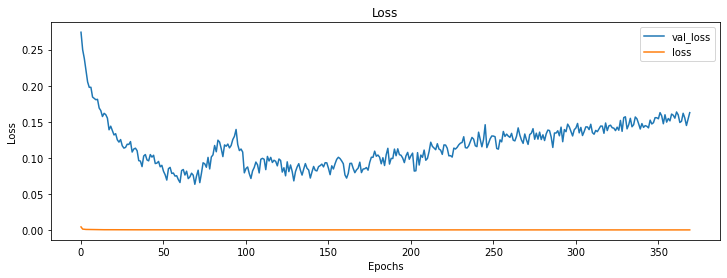

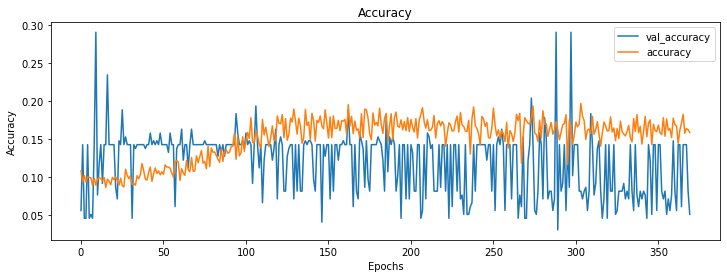

In [29]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

y_pred:
 [[20328.835339373956], [20297.44682528964], [20191.673121452488], [20122.044850565737], [20380.771936534868], [20470.127872529225], [20421.563268488575], [20358.7937670903], [20213.361510238283], [20235.66333080823]]
y_true:
 [[43537.511719], [42909.402344], [37002.441406], [40782.738281], [37304.691406], [37536.632813], [34770.582031], [38705.980469], [38402.222656], [39294.199219]]


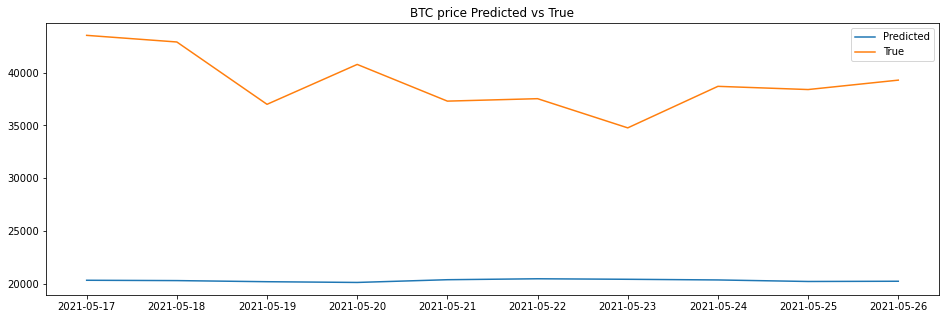

In [30]:
# Validation (validation with the last training days -> -15-15 DAYS)

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = sc.inverse_transform(y_train[-1].reshape(-1,1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df_train.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [31]:
# check the shape of the sc transform

y_pred:
 [[19761.55206597494], [19731.74229197316], [19630.988943964614], [19563.97810746976], [19815.686480080312], [19905.053706230206], [19860.401141082984], [19802.64070535778], [19664.110496923797], [19687.217681922022]]
y_true:
 [38436.96875, 35697.605469, 34616.066406, 35678.128906, 37332.855469, 36684.925781, 37575.179688, 39208.765625, 36894.40625, 35746.101563]


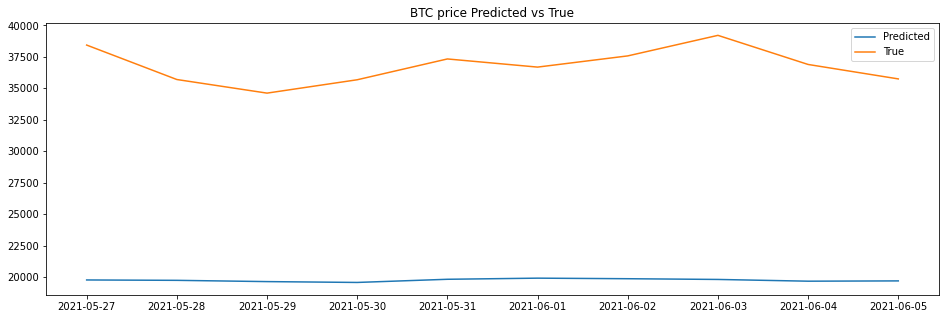

In [32]:
# Validation 2 (on the TEST SET -15 days)

# getting the predictions
x = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = df['Close'][-prediction_days:].values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [33]:
# evaluation
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [34]:
mean_absolute_error(y_true, y_pred)

17044.763228602045

In [35]:
explained_variance_score(y_true, y_pred)

0.08371538936835032

Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 (that is around 800) to get a relative error, as opposed to an absolute error. It is more relevant since for example if you get an RMSE of 50, then this error would be very big if the stock price values ranged around 100, but it would be very small if the stock price values ranged around 10000.

In [36]:
df.tail(n_past).values.shape

(30, 1)

In [37]:
x = df.tail(n_past).values
x = sc.transform(x)
x.reshape(1, n_past, 1).shape

(1, 30, 1)

In [38]:
df['Close'][-n_past:].values

array([57356.402344, 58803.777344, 58232.316406, 55859.796875,
       56704.574219, 49150.535156, 49716.191406, 49880.535156,
       46760.1875  , 46456.058594, 43537.511719, 42909.402344,
       37002.441406, 40782.738281, 37304.691406, 37536.632813,
       34770.582031, 38705.980469, 38402.222656, 39294.199219,
       38436.96875 , 35697.605469, 34616.066406, 35678.128906,
       37332.855469, 36684.925781, 37575.179688, 39208.765625,
       36894.40625 , 35746.101563])

y_pred:
 [[19897.801662990536], [19868.32306688449], [19765.161152361474], [19698.11268201483], [19953.268315449222], [20044.065627967084], [19999.548544686302], [19939.567711705567], [19797.784056784458], [19819.882654554745]]
y_true:
 [38436.96875, 35697.605469, 34616.066406, 35678.128906, 37332.855469, 36684.925781, 37575.179688, 39208.765625, 36894.40625, 35746.101563]


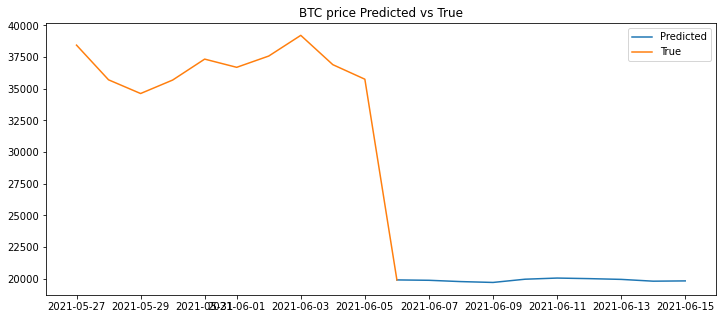

In [39]:
# Forecasting/Predicting

# getting the predictions
x = df['Close'][-n_past:].values.reshape(-1,1)
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df.index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df.columns)

# getting the true values
y_true_df = df.tail(prediction_days)

# linking them
y_true_df = y_true_df.append(y_pred_df.head(1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(12,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

#dates = df.index[-prediction_days:]
#dates = [str(dates.date[i]) for i in range(len(dates))]
#plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [40]:
regressor.save('regressor.h5')
#loaded_regressor = load_model('regressor.h5')
#loaded_regressor.predict(new_x)

**Improving the RNN**

Here are different ways to improve the RNN model:

Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.

Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).

Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.

**Evaluating the RNN**

As seen in the practical lectures, the RNN we built was a regressor. Indeed, we were dealing with Regression because we were trying to predict a continuous outcome (the Google Stock Price). For Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.

However for our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price.

Nevertheless if you are interested in the code that computes the RMSE for our Stock Price Prediction problem, please find it just below:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 (that is around 800) to get a relative error, as opposed to an absolute error. It is more relevant since for example if you get an RMSE of 50, then this error would be very big if the stock price values ranged around 100, but it would be very small if the stock price values ranged around 10000.

Enjoy Deep Learning!